In [1]:
import os
from pathlib import Path

import numpy as np
from tqdm.notebook import trange
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from dpipe.io import load, choose_existing
from dpipe.torch import load_model_state

from neuroxo.environment import Field
from neuroxo.torch.module.zero_net import NeuroXOZeroNN
from neuroxo.players import MCTSZeroPlayer


n = 10

In [2]:
base_path = choose_existing(
        Path('/home/boris/Desktop/workspace/experiments/rl/zero/'),
        Path('/shared/experiments/rl/ttt_10x10/'),
        Path('/gpfs/gpfs0/b.shirokikh/experiments/rl/ttt_10x10/'),
    )

os.listdir(base_path)

['zero_v4_parallel', 'zero_v3', 'tb8_v0']

In [3]:
exp_name = 'zero_v4_parallel'
sorted(os.listdir(base_path / exp_name))

['config_data_gen.json',
 'config_train.json',
 'config_train_1.json',
 'config_train_2.json',
 'data_epoch_2',
 'data_epoch_20',
 'data_epoch_21',
 'data_epoch_22',
 'data_epoch_23',
 'data_epoch_24',
 'data_epoch_25',
 'data_epoch_26',
 'data_epoch_27',
 'data_epoch_28',
 'data_epoch_29',
 'data_epoch_30',
 'data_epoch_31',
 'data_epoch_32',
 'data_epoch_33',
 'data_epoch_34',
 'data_epoch_35',
 'data_epoch_36',
 'data_epoch_37',
 'logs',
 'logs_1',
 'logs_2',
 'models',
 'vis_det',
 'vis_det_full',
 'vis_nondet']

In [4]:
vis_name = 'vis_det_full'
os.listdir(base_path / exp_name / vis_name)

['p.npy', 'n.npy', 'v_resign.npy', 'pi.npy', 'v.npy', 'a.npy', 's.npy']

# Visualization

In [5]:
s_history = load(base_path / exp_name / vis_name / 's.npy')
pi_history = load(base_path / exp_name / vis_name / 'pi.npy')
p_history = load(base_path / exp_name / vis_name / 'p.npy')
n_history = load(base_path / exp_name / vis_name / 'n.npy')

a_history = load(base_path / exp_name / vis_name / 'a.npy')
v_history = load(base_path / exp_name / vis_name / 'v.npy')
v_resign_history = load(base_path / exp_name / vis_name / 'v_resign.npy')

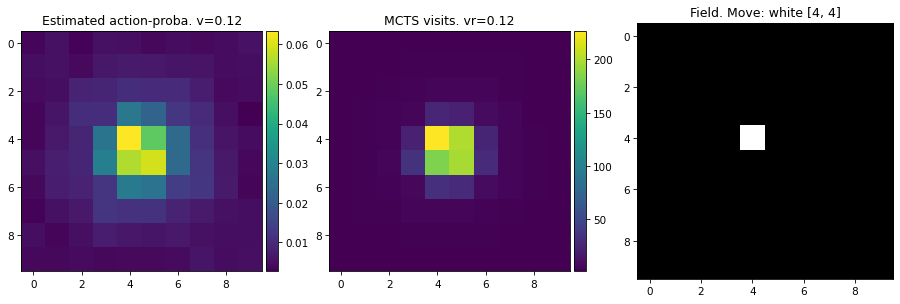

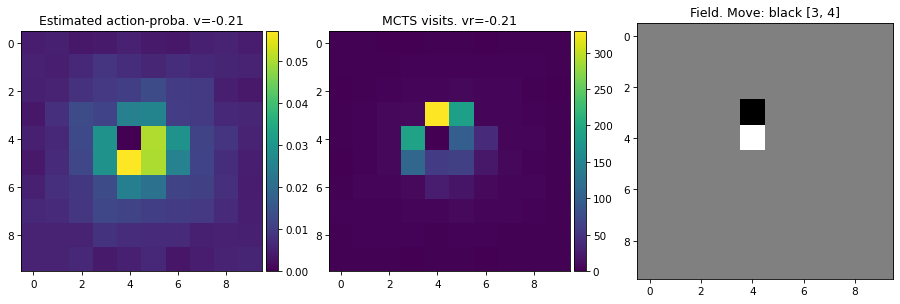

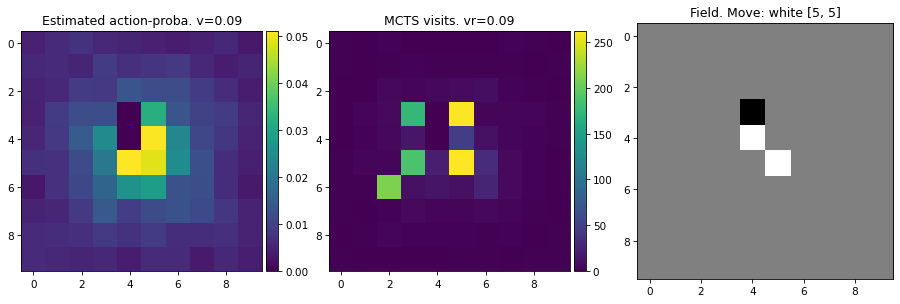

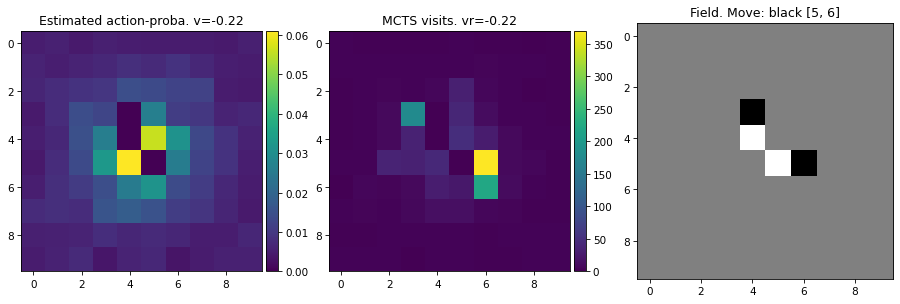

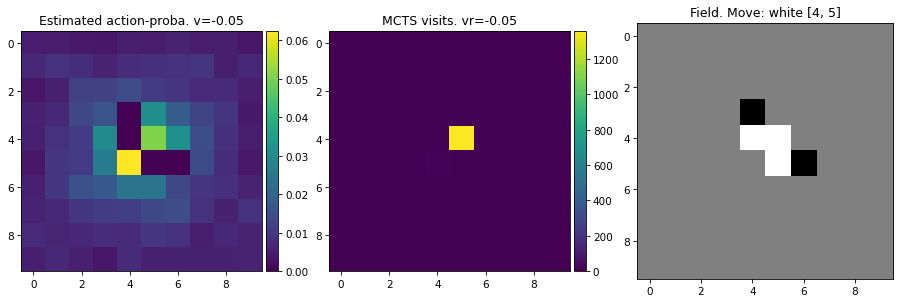

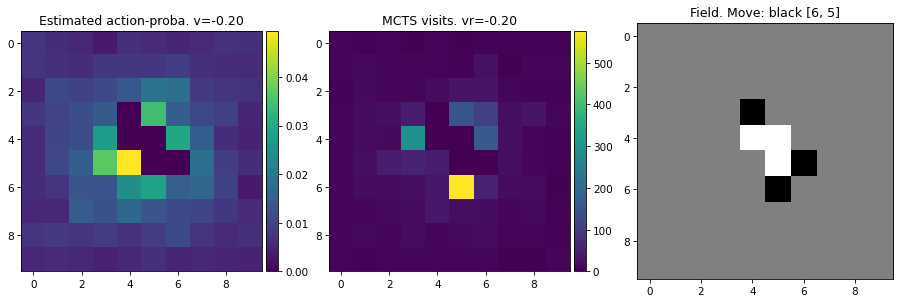

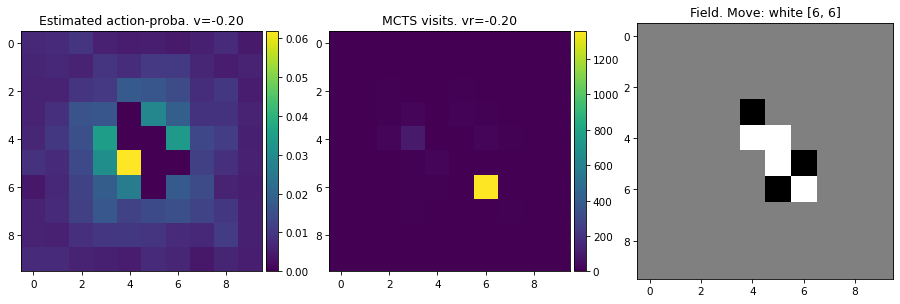

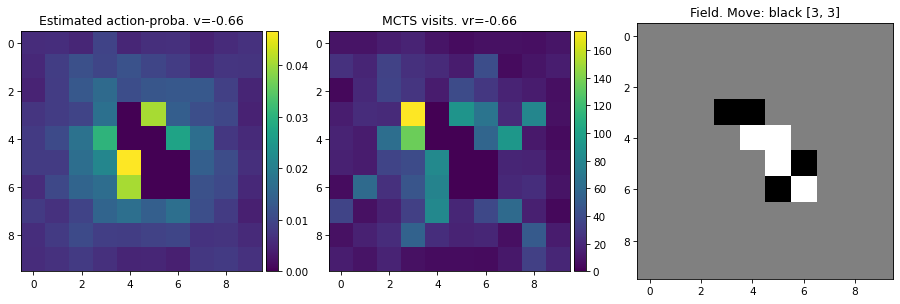

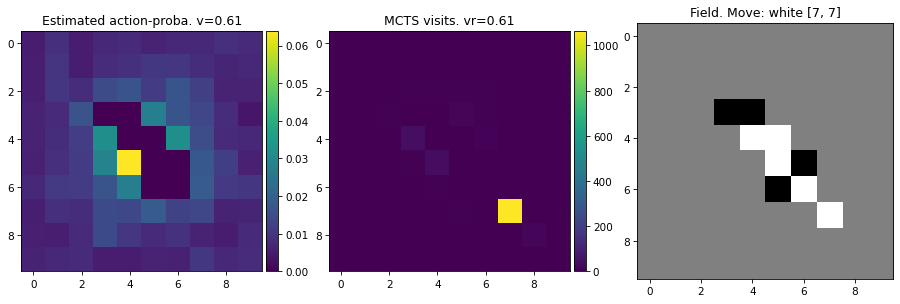

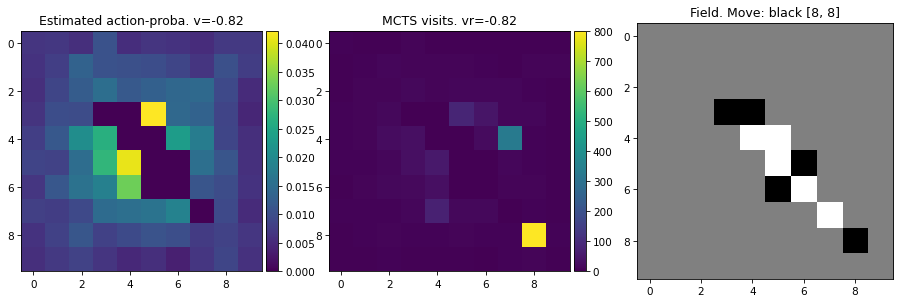

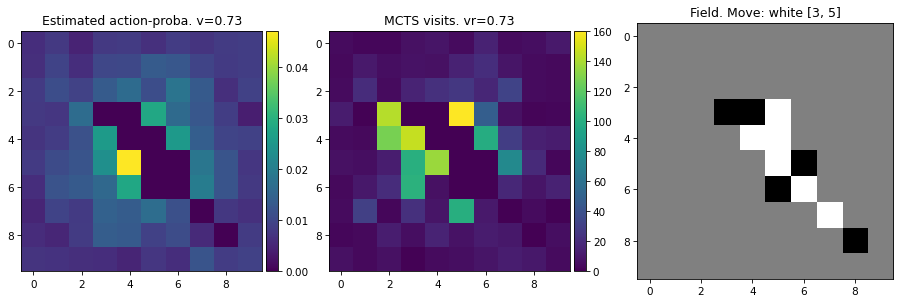

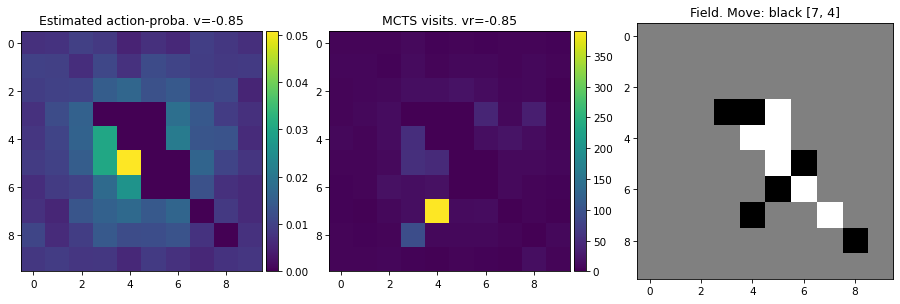

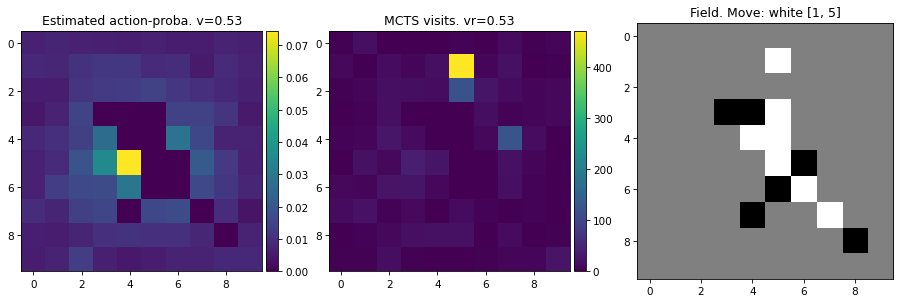

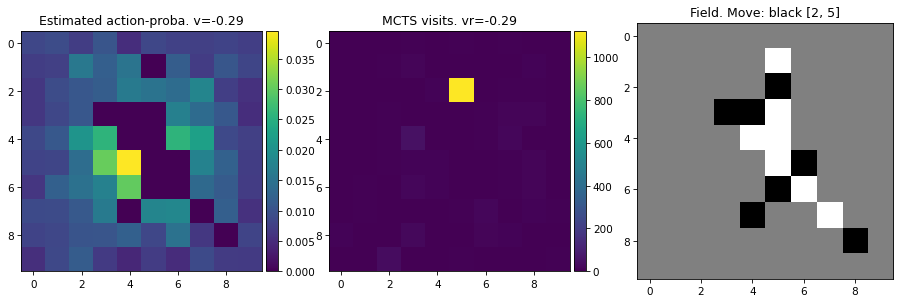

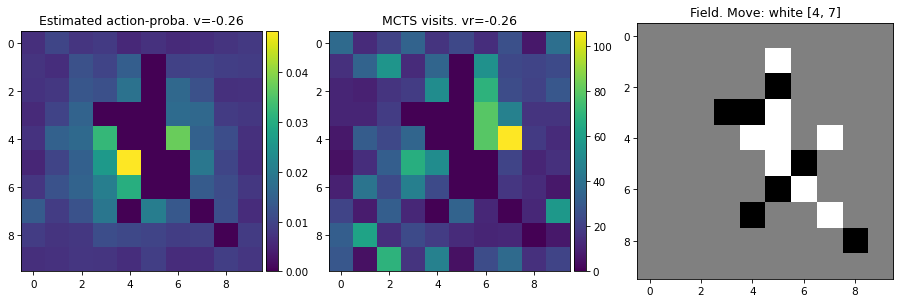

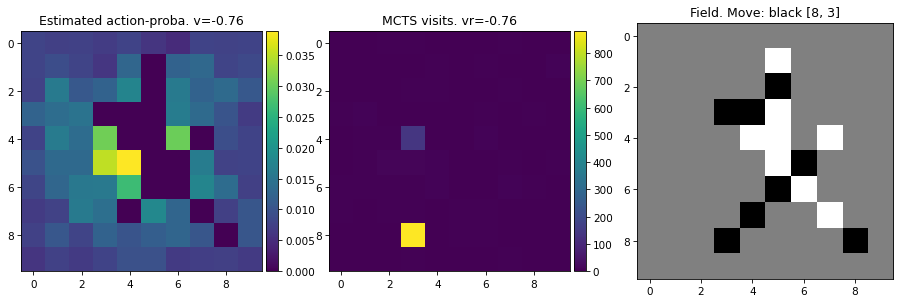

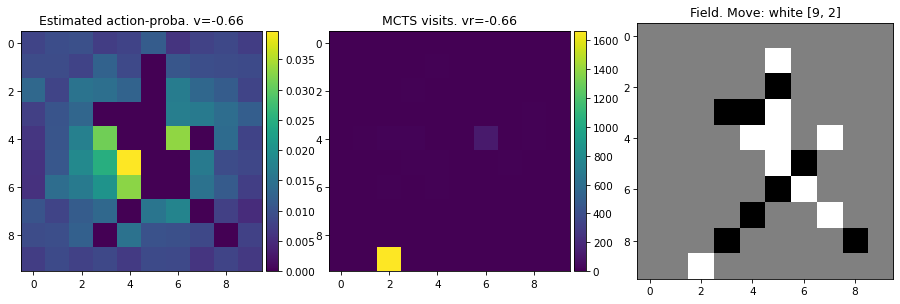

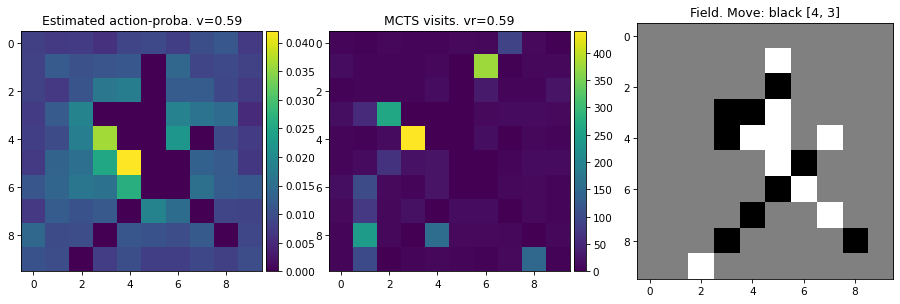

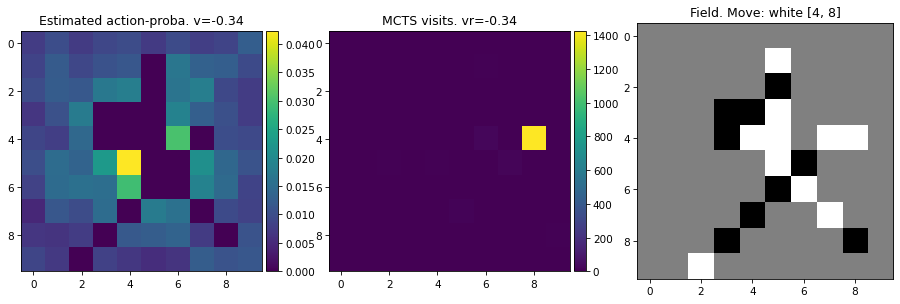

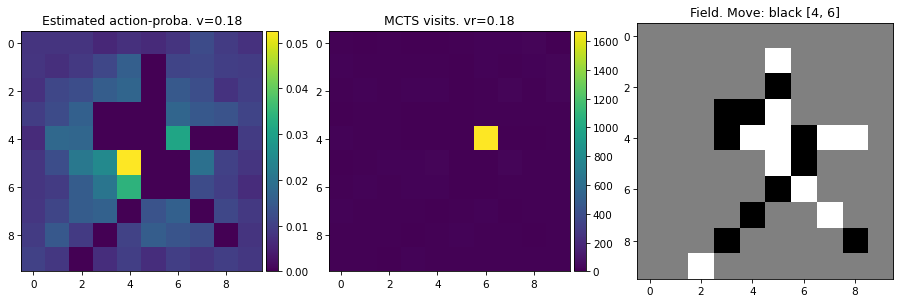

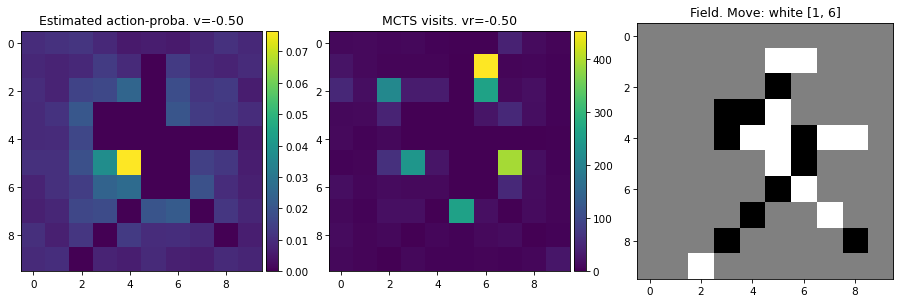

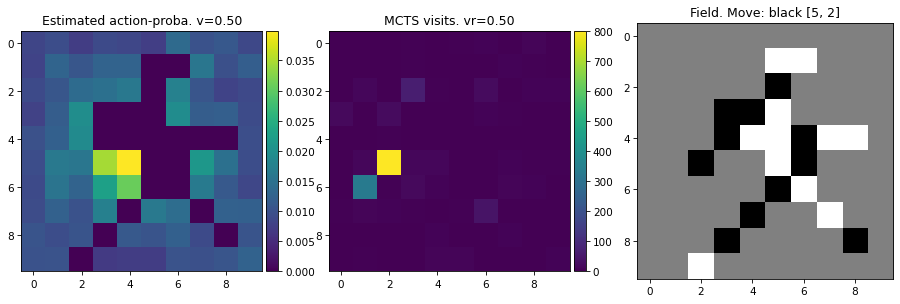

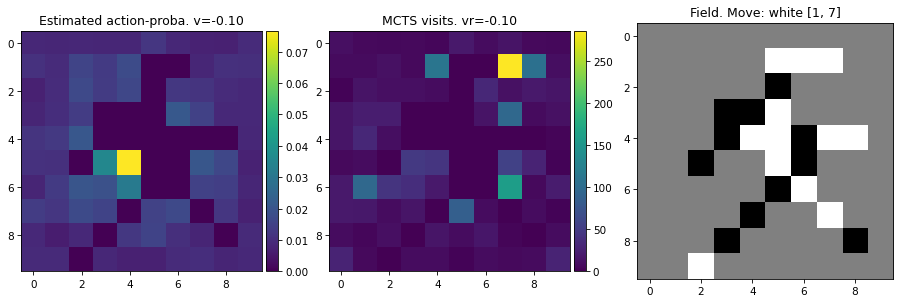

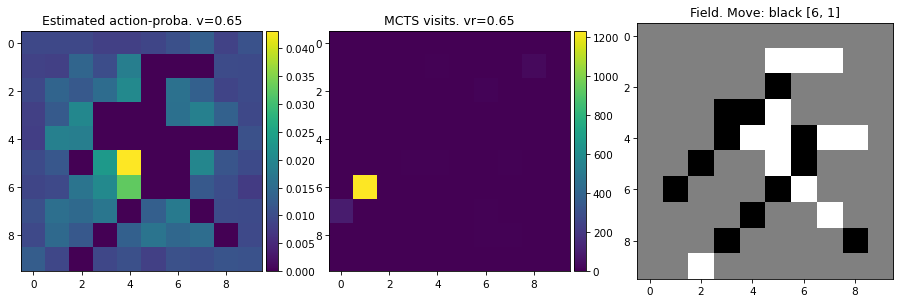

In [6]:
field_v = Field(10, 5)

for s, p, N, a, v, v_resign in zip(s_history, p_history, n_history, a_history, v_history, v_resign_history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=75)
    
    im = axes[0].imshow(p, interpolation='None')
    axes[0].set_title(f'Estimated action-proba. v={v:.2f}')
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = axes[1].imshow(N, interpolation='None')
    axes[1].set_title(f'MCTS visits. vr={v_resign:.2f}')
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    i, j = a // n, a % n
    field_v.set_field(s)
    field_v.make_move(i, j)
    _state = field_v.get_field()
    _player = {-1: 'black', 1: 'white'}[field_v.get_opponent_action_id()]
    
    axes[2].imshow(_state, cmap='gray')
    axes[2].set_title(f'Field. Move: {_player} [{i}, {j}]')
    
    plt.show()